# Test our Ecohydrology module

This notebook is to test that importing and using our implementation of the Ecohydrology model works. 

In [1]:
from ecohydr_mod import EcoHyd
import numpy as np

In [2]:
WSA_array = np.zeros((51,51))
# Set 20 random values to 1
indices_to_set = np.random.choice(range(51 * 51), size=20, replace=False)
row_indices, col_indices = np.unravel_index(indices_to_set, (51, 51))
WSA_array[row_indices, col_indices] = int(1)

Ecohyd_model = EcoHyd()

In [3]:
import matplotlib.pyplot as plt

In [4]:
biomass_harvest, SM_canic_end = Ecohyd_model.stepper(WSA_array)

0
0
soil moisture sat.: [ 0.62674488  0.62666621  0.62659056 ...,  0.65270531  0.65274503
  0.65278619]
live biomass:  [ 101.04441289  101.04472874  101.04503227 ...,   99.5811424    99.5811424
   99.5811424 ]
ET:  [ 11.8856614   11.90234503  11.91838473 ...,   6.20548215   6.19649334
   6.18717901]
ET30:  [ 11.8856614   11.90234503  11.91838473 ...,   6.20548215   6.19649334
   6.18717901]
PFT:  [0 0 0 ..., 0 0 0]
0
0
soil moisture sat.: [ 0.5548038   0.55464994  0.55450194 ...,  0.60389038  0.60396321
  0.60403865]
live biomass:  [ 100.07991358  100.08052803  100.0811185  ...,   97.21964628   97.21964628
   97.21964628]
ET:  [ 11.8856614   11.90234503  11.91838473 ...,   6.20548215   6.19649334
   6.18717901]
ET30:  [ 11.8856614   11.90234503  11.91838473 ...,   6.20548215   6.19649334
   6.18717901]
PFT:  [0 0 0 ..., 0 0 0]
1
0.0027397260273972603
soil moisture sat.: [ 0.38364454  0.38323202  0.38283534 ...,  0.51760103  0.51779752
  0.51800105]
live biomass:  [ 0.  0.  0. ...,  0. 

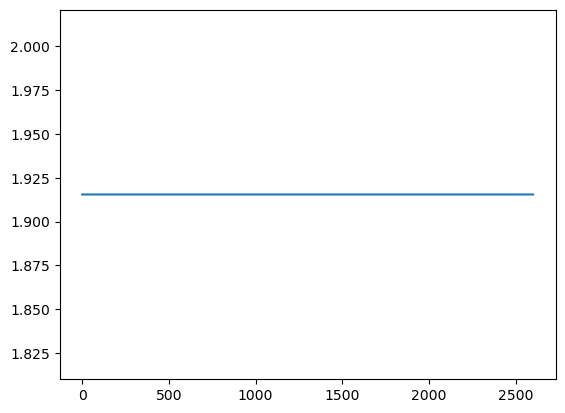

In [5]:
plt.plot(Ecohyd_model.mg.at_cell['rainfall__daily_depth'])

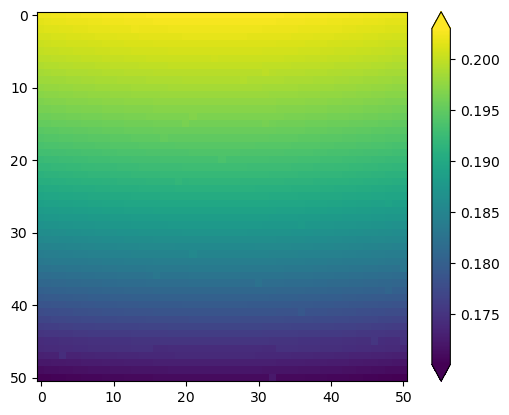

In [6]:
plt.imshow(np.reshape(Ecohyd_model.mg.at_cell['surface__evapotranspiration'], (51,51)))
plt.colorbar(extend = 'both')

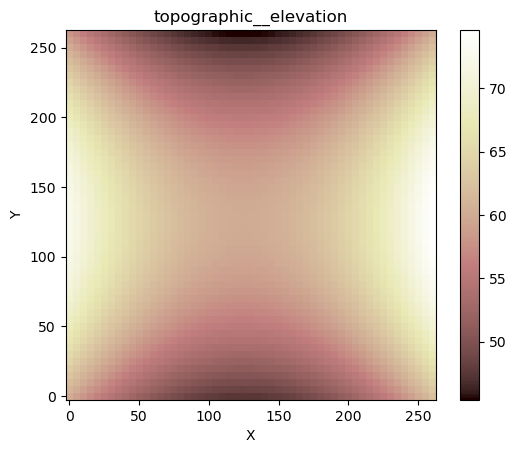

In [7]:
from landlab.plot.imshow import imshow_grid_at_node
#N.B. the Landlab user guide tells you to import the wrong component here

plt.figure('Elevations from the field')  # new fig, with a name
imshow_grid_at_node(Ecohyd_model.mg, 'topographic__elevation') 
plt.show()

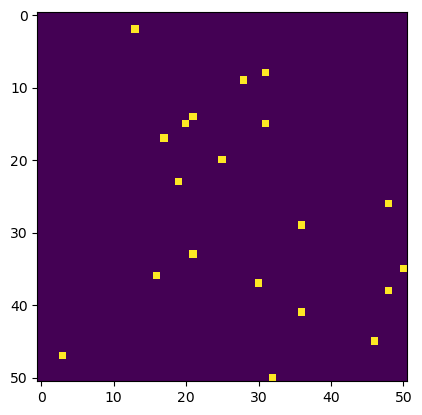

In [8]:
plt.imshow(WSA_array)

N.B the following images are all flipped upside-down because np.reshape assumes by default that the origin is in the top left, not the bottom left.

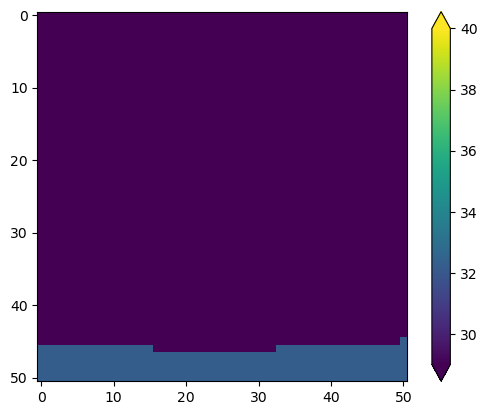

In [9]:
plt.imshow(np.reshape(biomass_harvest, (51,51)), vmin=40)
plt.colorbar(extend = 'both')

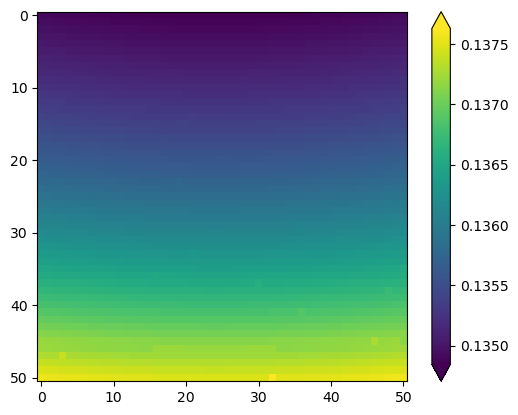

In [10]:
plt.imshow(np.reshape(SM_canic_end, (51,51)))
plt.colorbar(extend = 'both')

Why does WSA decrease soil moisture? A bit sus... Maybe there is still enough rainfall that the cover crop interception leads to less SM.

Almost more importantly though, we need to figure out what causes the weird artifact at the bottom of the plot (i.e., the North of the domain). Why is soil moisture there so much lower? As-is, this will dominate any potential effects from WSA.

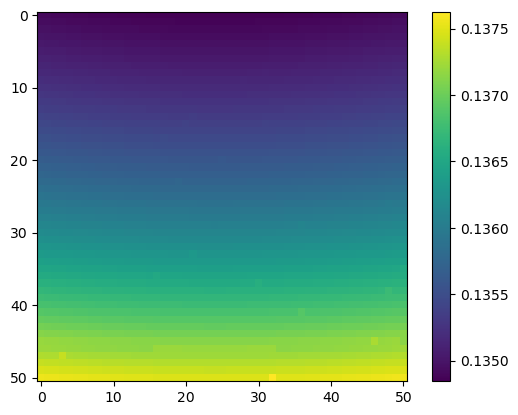

In [11]:
SM = np.reshape(Ecohyd_model.mg.at_cell['soil_moisture__saturation_fraction'], (51,51))
plt.imshow(SM)
plt.colorbar()

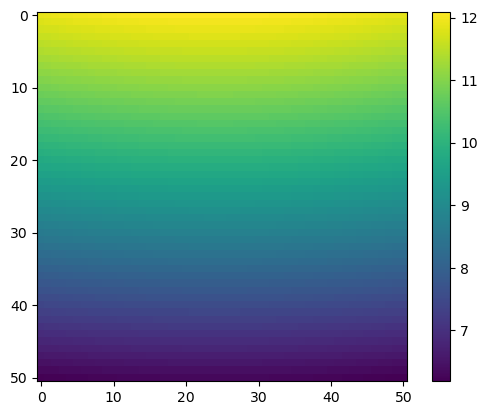

In [12]:
ET = np.reshape(Ecohyd_model.mg.at_cell['surface__potential_evapotranspiration_rate'], (51,51))
plt.imshow(ET)
plt.colorbar()

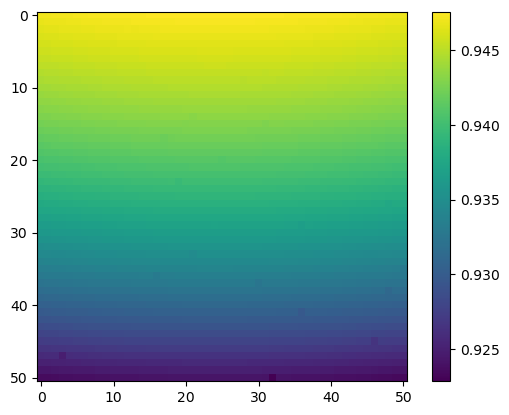

In [13]:
WS = np.reshape(Ecohyd_model.mg.at_cell['vegetation__water_stress'], (51,51))
plt.imshow(WS)
plt.colorbar()

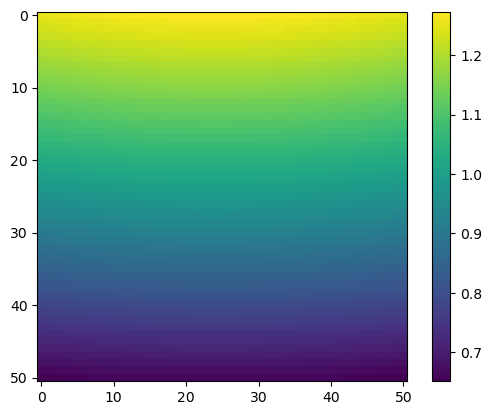

In [14]:
Rad_slope = np.reshape(Ecohyd_model.mg.at_cell['radiation__ratio_to_flat_surface'], (51,51))
plt.imshow(Rad_slope)
plt.colorbar()